<a href="https://colab.research.google.com/github/Valdi35/Detect-HFT-traders-Machine-learning-/blob/main/HFT_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture et nettoyage des donnees 


Le but du challenge est de construire un modèle de machine learning pouvant prédire les trois catégories de traders (HFT, non HFT et MIX). Au delà d'obtenir une meilleure accuracy, le second objectif consiste à choisir les variables les plus pertinentes.

In [ ]:
#Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path_folder_data_drive = '/content/gdrive/MyDrive/Colab_Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from os import listdir
from os.path import isfile, join
mypath = path_folder_data_drive+"Challenge_AMF"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

['HFT_machine_learning.ipynb', 'AMF_train_X.csv', 'AMF_train_Y.csv', 'AMF_test_X.csv']


In [ ]:
df = pd.read_csv(os.path.join(mypath, 'AMF_train_X.csv'))
y_train = pd.read_csv(os.path.join(mypath, 'AMF_train_Y.csv'))

In [ ]:
df.columns = df.columns.str.lower()
y_train.columns = y_train.columns.str.lower()

In [ ]:
df.head()

,index,share,day,trader,otr,ocr,omr,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,nbtradevenuemic,maxnbtradesbysecond,meannbtradesbysecond,min_dt_tv1,mean_dt_tv1,med_dt_tv1,min_dt_tv1_tv2,mean_dt_tv1_tv2,med_dt_tv1_tv2,min_dt_tv1_tv3,mean_dt_tv1_tv3,med_dt_tv1_tv3,min_dt_tv1_tv4,mean_dt_tv1_tv4,med_dt_tv1_tv4,nbsecondwithatleatonetrade
0,1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,23151.83800,25139.598,682.153260,8272.770569,682.153260,984.32056,682.15326,23151.83800,23151.8380,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,2671.48830,31278.357,11.866026,3796.632686,11.866026,177.93991,73.74323,808.26230,21433.6840,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
2,3,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,448.88360,30799.467,2.761036,1397.103679,2.761036,187.99548,19.77734,418.23984,1953.6235,10842.464,1,20,5.063492,0.000018,163.954785,0.000770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
3,4,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,19187.71900,19187.719,286.019320,9736.869034,286.019320,286.01932,286.01932,19187.71900,19187.7190,19187.719,1,8,4.250000,0.000148,1232.562133,0.004301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,5,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,273.45676,23164.514,2.798452,10066.803992,2.798452,1345.95280,662.57434,21903.78300,23164.5140,23164.514,1,19,3.710526,0.000025,248.073927,0.001364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38


In [ ]:
y_train.head()

,trader,type
0,Trader_285,MIX
1,Trader_114,NON HFT
2,Trader_110,NON HFT
3,Trader_57,NON HFT
4,Trader_128,NON HFT


In [ ]:
#Join the two df on trader id
data = pd.merge(df, y_train, how="inner", on=["trader"])

List of features
x_Train and x_test data exhibit in their rows the same 35 features calculated for a given market player i on a certain stock Isin_iIsin 
i
​	
  (whose identification code is an Isin) and a specific trading date tt :


- Number of trading venues on which the market player trades ;

- From all trading venues, statistics over the number of trades observed per second : #2 the mean, and, the max

- Statistics over the observed time delta between two trades on the trading venue TV_1[1] : min, median, mean

Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_2 : min, median, mean

- Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_3 : min, median, mean

- Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_4 : min, median, mean

- From all trading venues, number of seconds during the trading day where at least one trade of the market player i is observed
on trading venue TV_1;

- Three ratios between the number of all types of events[2] sent to the LOB and :
the number of trades (OTR),
the number of cancellation-type event (OCR),
the number of modification-type event (OMR);

- On trading venue TV_1, statistics over the observed time delta between two all-type events sent :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

- On trading venue TV_1, statistics over the observed lifetime of cancelled orders :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

The features above are not detailed in the same order as in the challenge files.


[1] TV_1 is the trading venue with the highest volume traded
[2] Events include both the transactions and the messages that market players can send to the LOB: new order, order modification or order cancellation.

In [ ]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105782 entries, 0 to 105781
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   index                       105782 non-null  int64  
 1   share                       105782 non-null  object 
 2   day                         105782 non-null  object 
 3   trader                      105782 non-null  object 
 4   otr                         104099 non-null  float64
 5   ocr                         105782 non-null  float64
 6   omr                         58170 non-null   float64
 7   min_time_two_events         105782 non-null  float64
 8   mean_time_two_events        105782 non-null  float64
 9   10_p_time_two_events        105782 non-null  float64
 10  med_time_two_events         105782 non-null  float64
 11  25_p_time_two_events        105782 non-null  float64
 12  75_p_time_two_events        105782 non-null  float64
 13  90_p_time_two_

In [ ]:
#Remove columns with null values more than a threeshold (0.2)
df.isnull().mean()

index                         0.000000
share                         0.000000
day                           0.000000
trader                        0.000000
otr                           0.015910
ocr                           0.000000
omr                           0.450095
min_time_two_events           0.000000
mean_time_two_events          0.000000
10_p_time_two_events          0.000000
med_time_two_events           0.000000
25_p_time_two_events          0.000000
75_p_time_two_events          0.000000
90_p_time_two_events          0.000000
max_time_two_events           0.000000
min_lifetime_cancel           0.000000
mean_lifetime_cancel          0.000000
10_p_lifetime_cancel          0.000000
med_lifetime_cancel           0.000000
25_p_lifetime_cancel          0.000000
75_p_lifetime_cancel          0.000000
90_p_lifetime_cancel          0.000000
max_lifetime_cancel           0.000000
nbtradevenuemic               0.000000
maxnbtradesbysecond           0.000000
meannbtradesbysecond     

In [ ]:
df = df[df.columns[df.isnull().mean() < 0.2]]

In [ ]:
del df['index']

In [ ]:
df.describe()

,otr,ocr,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,nbtradevenuemic,maxnbtradesbysecond,meannbtradesbysecond,min_dt_tv1,mean_dt_tv1,med_dt_tv1,nbsecondwithatleatonetrade
count,104099.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,101547.000000,101547.000000,101547.000000,105782.000000
mean,34.435038,17.458787,87.472164,2772.513578,103.310102,1011.630575,228.659560,4734.942457,9786.032539,24292.035085,1945.038027,5616.519744,2070.233540,4445.109364,2707.080480,8451.108964,11587.949910,19980.278762,5.563896,25.249324,2.093446,438.447418,1082.427774,651.743386,334.034070
std,137.261154,71.843225,1549.972501,4985.149536,1617.051421,4967.426924,2319.866837,10431.964706,14256.357615,17772.438572,6672.112738,9140.189971,6809.714060,9372.947978,7531.875480,13270.509124,15667.418368,17654.559859,4.385260,35.264111,1.417188,2876.755745,3187.357171,2931.984342,644.816702
min,1.044444,2.000000,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,0.000007,0.000038,0.000016,0.000035,0.000028,0.000038,0.000038,0.000038,1.000000,1.000000,1.000000,0.000001,0.000001,0.000001,1.000000
25%,3.709023,2.753802,0.000000,69.365666,0.000000,1.243868,0.000024,22.249021,117.771340,4410.907350,0.000583,67.897392,0.043414,6.234451,0.746623,30.724017,109.431107,1902.260450,2.000000,6.000000,1.500000,0.000007,50.921032,4.915512,24.000000
50%,7.346154,4.789474,0.000000,262.325253,0.000109,10.154920,0.093957,114.957445,480.715195,30166.389500,0.044144,272.333702,1.663752,35.734245,8.251923,182.259375,596.792220,17972.680000,5.000000,14.000000,1.880000,0.000091,183.022816,36.457000,97.000000
75%,22.707956,16.366667,0.000000,3801.273320,0.020739,60.552090,2.836749,2277.450350,20975.263250,37485.990000,35.497842,9185.177948,69.218030,2075.455025,254.888130,16302.060250,23952.383000,35716.844000,8.000000,30.000000,2.313703,0.001000,714.761762,227.236491,342.000000
max,17561.000000,14409.000000,52568.766000,52568.765625,52568.766000,52568.766000,52568.766000,60597.414000,60609.660000,71934.490000,53171.766000,53171.765625,53171.766000,53171.766000,53171.766000,53646.010000,53909.210000,53909.210000,24.000000,909.000000,63.000000,30929.771000,30929.771000,30929.771000,12966.000000


In [ ]:
df.isnull().sum()

share                            0
day                              0
trader                           0
otr                           1683
ocr                              0
min_time_two_events              0
mean_time_two_events             0
10_p_time_two_events             0
med_time_two_events              0
25_p_time_two_events             0
75_p_time_two_events             0
90_p_time_two_events             0
max_time_two_events              0
min_lifetime_cancel              0
mean_lifetime_cancel             0
10_p_lifetime_cancel             0
med_lifetime_cancel              0
25_p_lifetime_cancel             0
75_p_lifetime_cancel             0
90_p_lifetime_cancel             0
max_lifetime_cancel              0
nbtradevenuemic                  0
maxnbtradesbysecond              0
meannbtradesbysecond             0
min_dt_tv1                    4235
mean_dt_tv1                   4235
med_dt_tv1                    4235
nbsecondwithatleatonetrade       0
type                

In [ ]:
#Replace NaN values by 0
df.fillna(0,inplace=True)

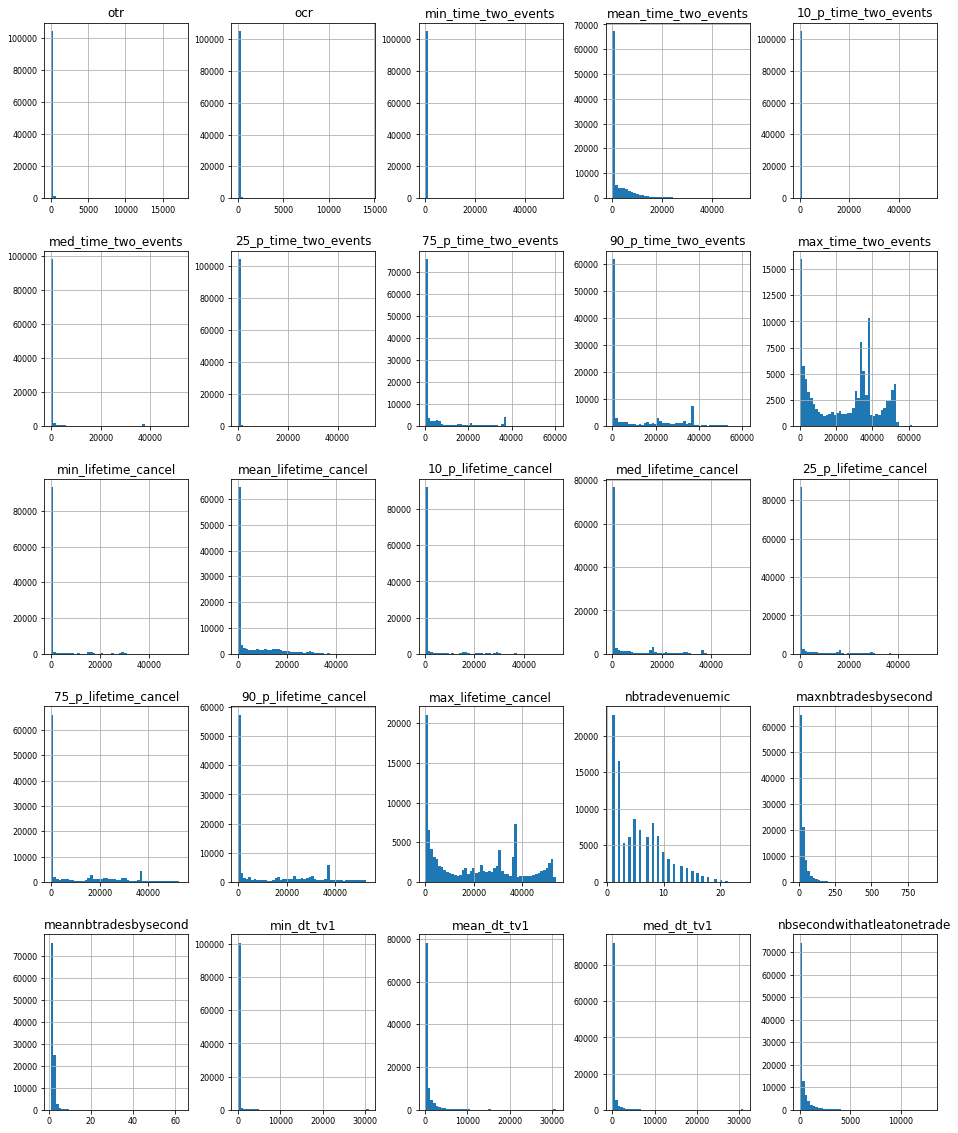

In [ ]:
numerical_column = ['int64','float64']
df.select_dtypes(include=numerical_column).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [ ]:
#Create two features 
df['lifetime_cancel'] = df['10_p_lifetime_cancel'] + df['90_p_lifetime_cancel']
df['time_two_events'] = df['10_p_time_two_events'] + df['90_p_time_two_events']

In [ ]:
#Features to drop from the dataframe
toDrop = ['min_time_two_events','10_p_time_two_events','med_time_two_events',
          '25_p_time_two_events','75_p_time_two_events','90_p_time_two_events',
          'min_lifetime_cancel','10_p_lifetime_cancel','med_lifetime_cancel',
          '25_p_lifetime_cancel','75_p_lifetime_cancel','90_p_lifetime_cancel','max_lifetime_cancel']

In [ ]:
#Drop features
for col in toDrop:
  del df[col]

# Analyse du jeu de donnees

In [ ]:
#On centre et reduit pour rendre les donnees homogenes
#RobustScaler est plus approprie pour des donnees qui contiennent des outliers
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaleData = scaler.fit_transform(df.select_dtypes(include=numerical_column))

In [ ]:
cols = df.select_dtypes(include=numerical_column).columns

In [ ]:
scaleData = pd.DataFrame(data= scaleData, columns=cols, index=df['trader'])

In [ ]:
nData = pd.merge(scaleData, y_train, how="inner", on=["trader"])

In [ ]:
#select only numerical features to find correlation
plt.figure(figsize=(15,15))
sns.heatmap(
    nData.corr(),
    cmap=plt.cm.RdBu,
    vmax=1.0,
    linewidths=0.1,
    linecolor='white',
    square=True,
    annot=True
)
plt.show()

In [ ]:
def correlation(dataset, threshold):
  #Supprime les variables fortement correlees
  col_corr = set() 
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [ ]:
corr_features = correlation(nData, 0.9)

In [ ]:
#Les variables fortement correles
corr_features

In [ ]:
#On supprime les variables fortement correles car l'apport marginal de chaque variable
#fortement correlees a une autre decroit dans le modele

#Le probleme avec la methode ci-dessus, c'est que nous n'avons pas le choix sur la variable a choisir
#entre deux vaiables correles 

df_ = nData.drop(['mean_lifetime_cancel','min_dt_tv1','mean_dt_tv1'],axis=1)

In [ ]:
sns.pairplot(df_[['otr','ocr','nbtradevenuemic','type']], hue="type")

Le nombre de lieu sur lesquels les MIX et HFT (entre 0 et 25) passent des ordres est en moyenne plus grand que celui des Non-HFT (entre 0 et 10)

In [ ]:
sns.pairplot(df_[['mean_time_two_events','meannbtradesbysecond','nbsecondwithatleatonetrade','type']], hue="type")

Les Non-HFT executent en moyenne moins d'ordre (a la seconde) et ont un nombre moyen de temps entre deux ordres plus eleves que les MIX et les HFT

In [ ]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=df_,
    x="otr", y="nbtradevenuemic", hue="type",
    height=5
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Number of trade", "Nb of trade venue mic")

In [ ]:
sns.displot(
    df_,
    x="nbtradevenuemic", col="type", hue="type",
    kind="ecdf", aspect=.75, linewidth=2
)

Les MIX sont egalement reparties sur le nombre de lieu d'echange possible, pendant que les NON HFT ont en majorite moins de cinq lieu d'echange (60%). Plus de 90% des HFT ont moins de 10 lieu d'echange

In [ ]:
sns.displot(
    df_,
    x="otr", col="type", hue="type",
    kind="ecdf", aspect=.75, linewidth=2
)

Les HFT passent plus d'ordres que les Non HFT et MIX.

In [ ]:
sns.displot(
    df_,
    x="meannbtradesbysecond", col="type", hue="type",
    kind="ecdf", aspect=.75, linewidth=2
)

Les trois categories ont un nombre assez similaires de trades moyen a la seconde

In [ ]:
sns.displot(
    df_,
    x="ocr", col="type", hue="type",
    kind="ecdf", aspect=.75, linewidth=2
)

Les MIX ont le plus grand nombre d'annulation d'ordres.

In [ ]:
df_.set_index('trader',inplace=True)

# Modelisation

In [ ]:
X = df_.loc[:,df_.columns != 'type']
Y = df_['type']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.3, random_state=42)

Support vector machine

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(str(model_type) + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
